# Introduction

The goal of this notebook is to generate various images that correspond to what various neural networks understand of the Mandelbrot set. This notebook was used to create the following [blog post](https://medium.com/@chatel.gregory/what-do-deep-neural-networks-understand-of-fractals-2ae354911601). 

In [1]:
%matplotlib inline
import keras
import itertools

from keras.layers         import Dense
from keras.models         import Model
from keras.models         import Sequential
from keras.utils.np_utils import to_categorical

from collections import Counter

import numpy             as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Tools definition

We define the maximum number of terms of the complex number sequence that we generate to detect the divergence. 

In [2]:
max_iter = 50
seq_fn   = lambda z, c: z ** 2 + c

This function will be used to compute the terms of the sequence. If a divergence is detected, it will return 1 and 0 otherwise.

In [3]:
def iterate_sequence(seq_fn, max_iter, c):
    z = c
    for i in range(max_iter):
        z = seq_fn(z, c)
        # mathematical criterion to detect the divergence
        if (z.real * z.real + z.imag * z.imag) > 4:
            return 1
    return 0

# Model results visualization

This function generate a sample of the complex plane between -2 and 1 for the real part and -1 and 1 for the imaginary part. 

In [4]:
def generate_X(unit):
    width       = 3 * unit
    height      = 2 * unit 
    real_values = np.linspace(-2, 1, width)
    imag_values = np.linspace(-1, 1, height)
    # we swap the two columns because the first loop should be on the imaginary parts
    # but for latter treatment, it makes more sense to have table (real, imag).
    result      = np.array(list(itertools.product(imag_values, real_values)))[:, (1, 0)]

    return result

This function utilizes the model to compute the color of each pixel of the final image. 

In [5]:
def generate_visualization(model, unit):
    height = 2 * unit
    width  = 3 * unit
    X      = generate_X(unit)
    y      = model.predict_classes(X, batch_size = 4096, verbose = 2)
    
    return y.reshape((height, width))

This class is just a small hack to show the function the various neural networks will try to approximate.

In [6]:
class FakeModel():
    def predict_classes(self, X, **kwargs):
        return np.array([iterate_sequence(seq_fn, max_iter, complex(*sample)) for sample in X])

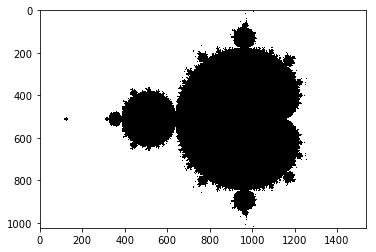

In [7]:
fake_model = FakeModel()
res        = generate_visualization(fake_model, 512)
plt.imshow(res, cmap = 'gray')

# Training samples generation

How many sample we will take along each axis to build the training set.

In [8]:
training_unit = 500
samples       = generate_X(training_unit)
sample_img    = np.array([iterate_sequence(seq_fn, max_iter, complex(*sample)) for sample in samples])
print(samples.shape, sample_img.shape)

(1500000, 2) (1500000,)


Now, for each sample, we compute its target (whether the sequence diverges or not for this complex number).

In [9]:
outside = samples[sample_img == 1]
inside  = samples[sample_img == 0]
X       = np.concatenate([inside, outside])
y       = np.concatenate([np.zeros(inside.shape[0]), np.zeros(outside.shape[0]) + 1]).astype(np.int32)
y       = to_categorical(y)

# Renderings

This function is used to create the various models that we will use. The architecture of the network corresponds to the parameters of the function with an additional fully connected layer with softmax activation at the end. This last layer is used to produce a prediction of the right shape.

In [10]:
def create_model(internal_layers_number, node_per_layer, activation, optimizer):
    model = Sequential([Dense(node_per_layer, input_dim = 2, activation = activation)])
    
    for _ in range(internal_layers_number - 1):
        model.add(Dense(node_per_layer, activation = activation))
        
    model.add(Dense(2, activation = 'softmax'))
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy')
    
    return model

In [11]:
def create_final_picture(model, internal_layers_number, node_per_layer, activation, folder):
    result = generate_visualization(model, 512)
    plt.imshow(result, cmap = 'gray')
    filename = folder + 'DL_mandelbrot_%d_layers_%03d_nodes_%s_activation.png' % (internal_layers_number, node_per_layer, activation)
    plt.savefig(filename)
    plt.close()

In [12]:
def generate_all_pictures(folder):
    for internal_layers_number in range(6, 0, -1):
        for node_per_layer in [512, 256, 128, 64, 32, 16, 8]:
            for activation in ['relu', 'tanh', 'sigmoid']:
                print('internal_layers_number', internal_layers_number)
                print('node_per_layer', node_per_layer)
                print('activation', activation)
                model = create_model(internal_layers_number, node_per_layer, activation, optimizer = 'adam')
                model.fit(X, y, batch_size = 4096, epochs = 20, verbose = 0)
                create_final_picture(model, internal_layers_number, node_per_layer, activation, folder)

In [ ]:
generate_all_pictures('../images/01/')